In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import scipy as sci

# Applied

### Problem 10

**Some quick data explorations**

In [2]:
weekly = pd.read_csv('Weekly.csv')
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [3]:
weekly.shape

(1089, 9)

In [4]:
1089/52

20.942307692307693

In [11]:
weekly.corr().round(3)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000,-0.032,-0.033,-0.030,-0.031,-0.031,0.842,-0.032
Lag1,-0.032,1.000,-0.075,0.059,-0.071,-0.008,-0.065,-0.075
Lag2,-0.033,-0.075,1.000,-0.076,0.058,-0.072,-0.086,0.059
Lag3,-0.030,0.059,-0.076,1.000,-0.075,0.061,-0.069,-0.071
Lag4,-0.031,-0.071,0.058,-0.075,1.000,-0.076,-0.061,-0.008
Lag5,-0.031,-0.008,-0.072,0.061,-0.076,1.000,-0.059,0.011
Volume,0.842,-0.065,-0.086,-0.069,-0.061,-0.059,1.000,-0.033
Today,-0.032,-0.075,0.059,-0.071,-0.008,0.011,-0.033,1.000


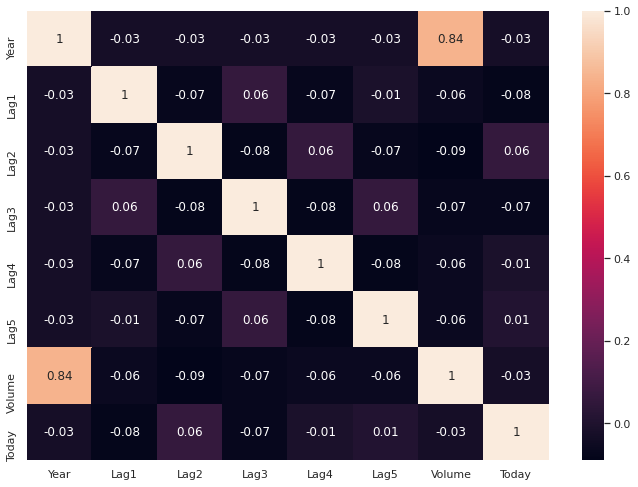

In [9]:
correlation_matrix = weekly.corr().round(2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

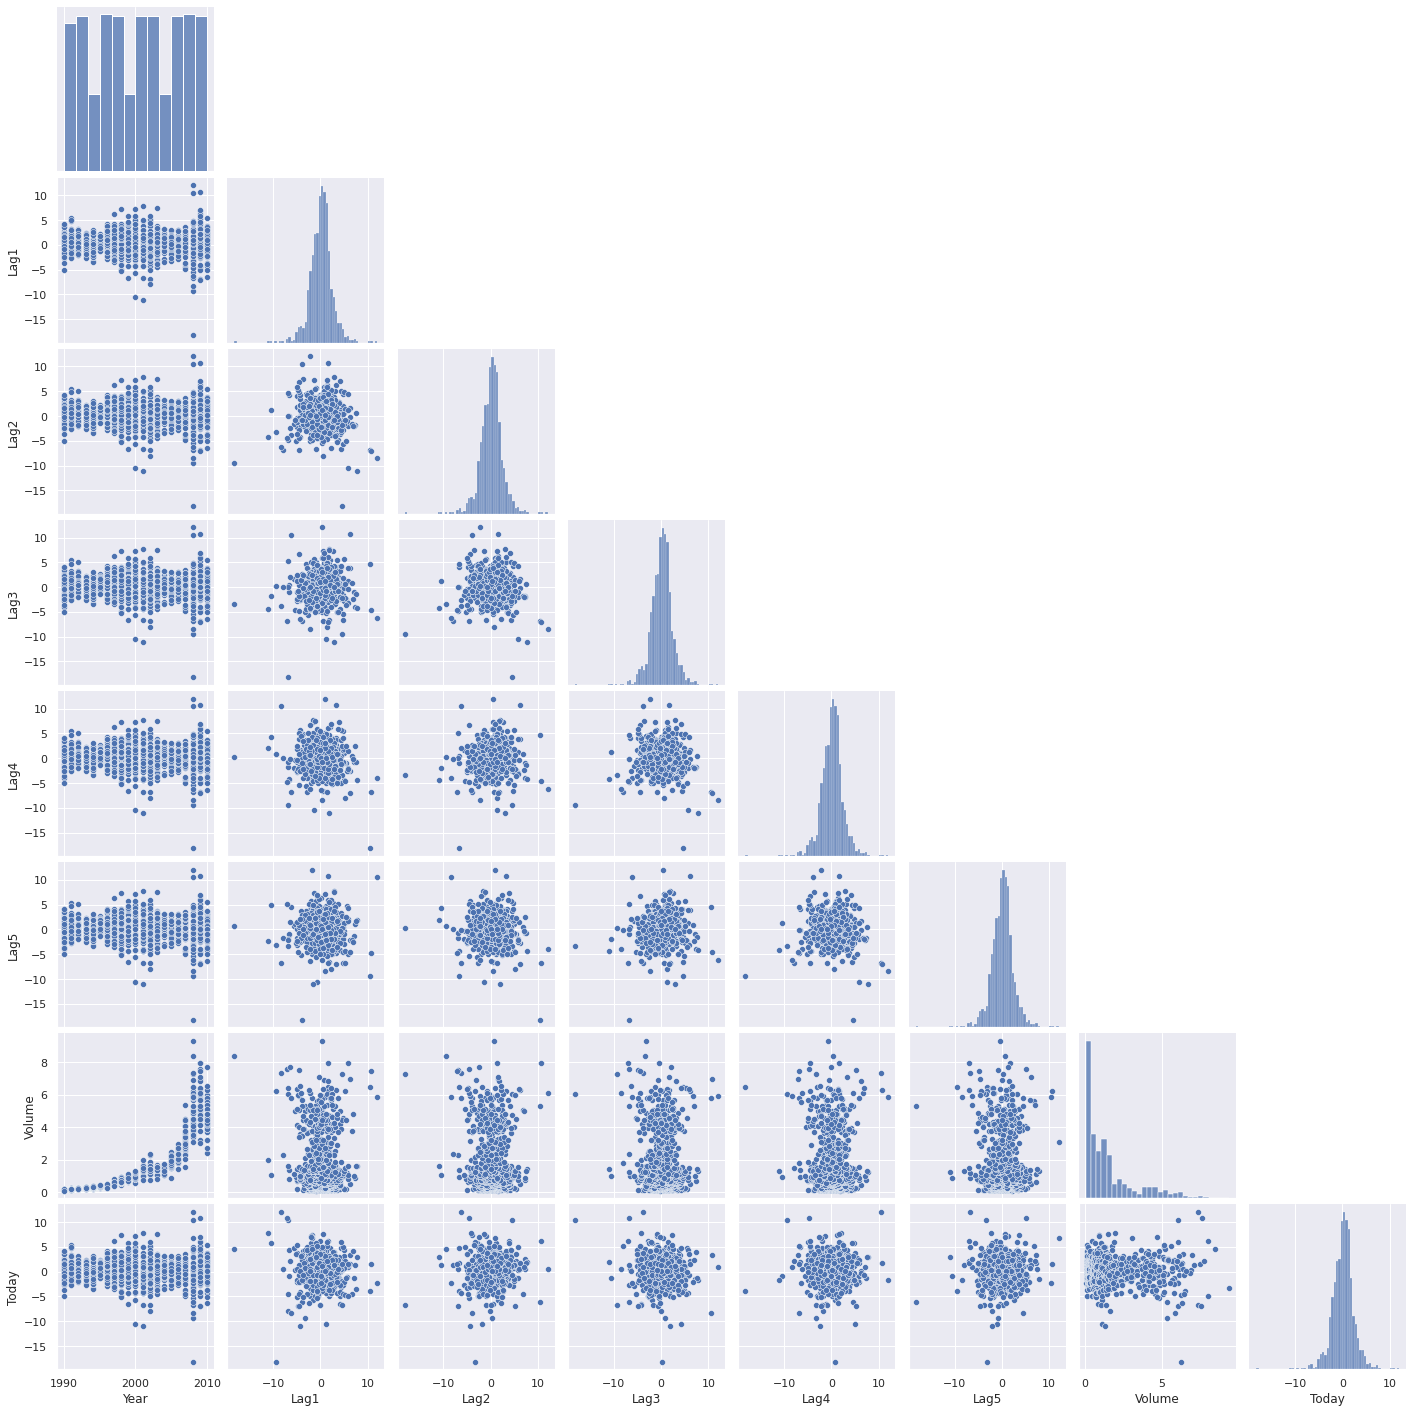

In [12]:
sns.pairplot(weekly, corner= True)

Notes from above visuals:  
Trade volume increase exponentially as years increase.  Other than that there are no real correlations.

**Logistic regression**

In [13]:
model = sm.GLM.from_formula('Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', family = sm.families.Binomial(), data = weekly)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                           
================================================================================================
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                 1089
Model:                                              GLM   Df Residuals:                     1082
Model Family:                                  Binomial   Df Model:                            6
Link Function:                                    logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -743.18
Date:                                  Fri, 23 Oct 2020   Deviance:                       1486.4
Time:                                          14:04:09   Pearson chi2:                 1.09e+03
No. Iterations:                                       4                                         
Covariance Type:                              nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2669      0.086     -3.106      0.002      -0.435      -0.098
Lag1           0.0413      0.026      1.563      0.118      -0.010       0.093
Lag2          -0.0584      0.027     -2.175      0.030      -0.111      -0.006
Lag3           0.0161      0.027      0.602      0.547      -0.036       0.068
Lag4           0.0278      0.026      1.050      0.294      -0.024       0.080
Lag5           0.0145      0.026      0.549      0.583      -0.037       0.066
Volume         0.0227      0.037      0.616      0.538      -0.050       0.095
==============================================================================
"""

Only Lag2 seems to have statistical evidence of there being a relationship with the DV

**Computing Confusion Matrix using SKLearn**

In [14]:
from sklearn.linear_model import LogisticRegression
indicators = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
response = 'Direction'

X = weekly[indicators]
Y = weekly[response]

In [15]:
logreg = LogisticRegression(C=1e19)
logreg.fit(X,Y)

LogisticRegression(C=1e+19)

In [17]:
predictions = logreg.predict(X)

In [25]:
#confusion matrix
from sklearn.metrics import confusion_matrix
columnName = pd.MultiIndex.from_product([['Predict'],logreg.classes_])
indexName = pd.MultiIndex.from_product([['True'], logreg.classes_])
cmatrix = confusion_matrix(Y, predictions,labels=logreg.classes_)
print('Confusion Matrix: ')
display(pd.DataFrame(cmatrix, columns = columnName, index = indexName))

Confusion Matrix: 


Predict     
             Down   Up
True Down      54  430
     Up        48  557

In [26]:
#classication report
from sklearn.metrics import classification_report
print(classification_report(Y,predictions))

              precision    recall  f1-score   support

        Down       0.53      0.11      0.18       484
          Up       0.56      0.92      0.70       605

    accuracy                           0.56      1089
   macro avg       0.55      0.52      0.44      1089
weighted avg       0.55      0.56      0.47      1089



In [30]:
#error rate
x = 1-0.56
np.round(x,2)

0.44

In [32]:
#direction split ratio
weekly['DirectionBinary'] = weekly.Direction.replace({'Up':1,'Down':0})

In [34]:
weekly.DirectionBinary.mean()

0.5555555555555556

The logistic regression model is not performing much better than someone betting on Up every time.  Though it is predicting times that the market is moving down better

Seeing as the model has high recall for predicting up, it has a high true positive rate but a dismal false positive rate for predicting Upward movements.  Meaning, the model will capture Upward movements 92% of the time but at the expense of accurately predicting downward movements.

In [35]:
# fitting with only Lag2 train-test format
factors = 'Lag2'
dependent = 'Direction'

trainSet = weekly.loc[weekly.Year <= 2008,:]
testSet = weekly.loc[weekly.Year > 2008,: ]

In [50]:
X_train = trainSet.loc[:,[factors]]
Y_train = trainSet[dependent]

X_test = testSet.loc[:,[factors]]
Y_test = testSet[dependent]

In [51]:
logreg.fit(X_train,Y_train)

LogisticRegression(C=1e+19)

In [52]:
Y_pred = logreg.predict(X_test)

In [53]:
columnNames = pd.MultiIndex.from_product([['Predict'],logreg.classes_])
indexNames = pd.MultiIndex.from_product([['True'], logreg.classes_])
cmatrix = confusion_matrix(Y_test, Y_pred, labels=logreg.classes_)
print('Confusion Matrix: ')
display(pd.DataFrame(cmatrix, columns=columnNames, index = indexNames))

Confusion Matrix: 


Predict    
             Down  Up
True Down       9  34
     Up         5  56

In [55]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

        Down       0.64      0.21      0.32        43
          Up       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104



In [56]:
#fitting using LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,Y_train)

LinearDiscriminantAnalysis()

In [57]:
ldaY_pred = lda.predict(X_test)
cfmat_cnames = pd.MultiIndex.from_product([['Predict'], lda.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], lda.classes_])
cfmat = confusion_matrix(Y_test, ldaY_pred, labels=lda.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))


Confusion Matrix: 


Predict    
             Down  Up
True Down       9  34
     Up         5  56

In [58]:
print(classification_report(Y_test, ldaY_pred))

              precision    recall  f1-score   support

        Down       0.64      0.21      0.32        43
          Up       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104



In [59]:
#fitting using QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Fit on training subset
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, Y_train)
qdaY_pred = qda.predict(X_test)

# Evaluate accuracy
cfmat_cnames = pd.MultiIndex.from_product([['Predict'], qda.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], qda.classes_])
cfmat = confusion_matrix(Y_test, qdaY_pred, labels=qda.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

#classification report
print(classification_report(Y_test, qdaY_pred))


Confusion Matrix: 


Predict    
             Down  Up
True Down       0  43
     Up         0  61

              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        43
          Up       0.59      1.00      0.74        61

    accuracy                           0.59       104
   macro avg       0.29      0.50      0.37       104
weighted avg       0.34      0.59      0.43       104



/home/jordan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
Y_test.value_counts()

Up      61
Down    43
Name: Direction, dtype: int64

In [62]:
61/(61+43)

0.5865384615384616

In [65]:
#fitting KNN, K =1
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, Y_train)
knnY_pred  = knn.predict(X_test)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], knn.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], knn.classes_])
cfmat = confusion_matrix(Y_test, knnY_pred, labels=knn.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, knnY_pred))


Confusion Matrix: 


Predict    
             Down  Up
True Down      21  22
     Up        31  30

              precision    recall  f1-score   support

        Down       0.40      0.49      0.44        43
          Up       0.58      0.49      0.53        61

    accuracy                           0.49       104
   macro avg       0.49      0.49      0.49       104
weighted avg       0.51      0.49      0.49       104



In [66]:
#fitting KNN, K =3
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
knnY_pred  = knn.predict(X_test)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], knn.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], knn.classes_])
cfmat = confusion_matrix(Y_test, knnY_pred, labels=knn.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, knnY_pred))


Confusion Matrix: 


Predict    
             Down  Up
True Down      15  28
     Up        20  41

              precision    recall  f1-score   support

        Down       0.43      0.35      0.38        43
          Up       0.59      0.67      0.63        61

    accuracy                           0.54       104
   macro avg       0.51      0.51      0.51       104
weighted avg       0.53      0.54      0.53       104



In [70]:
#fitting KNN, K =5
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
knnY_pred  = knn.predict(X_test)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], knn.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], knn.classes_])
cfmat = confusion_matrix(Y_test, knnY_pred, labels=knn.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, knnY_pred))


Confusion Matrix: 


Predict    
             Down  Up
True Down      16  27
     Up        22  39

              precision    recall  f1-score   support

        Down       0.42      0.37      0.40        43
          Up       0.59      0.64      0.61        61

    accuracy                           0.53       104
   macro avg       0.51      0.51      0.50       104
weighted avg       0.52      0.53      0.52       104



### Problem 11

In [96]:
auto = pd.read_csv("Auto.csv")
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [97]:
mpgMed = auto.mpg.median()
auto['mpg01'] = np.select(
[
    (auto['mpg']>mpgMed)
],
[
    1
], default =0)

In [98]:
auto['originName'] = auto.origin.replace({1:"American",2:"Euro",3:'Japanese'})

In [99]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01,originName
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0,American
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0,American
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0,American
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0,American
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0,American


In [100]:
mpgMed

23.0

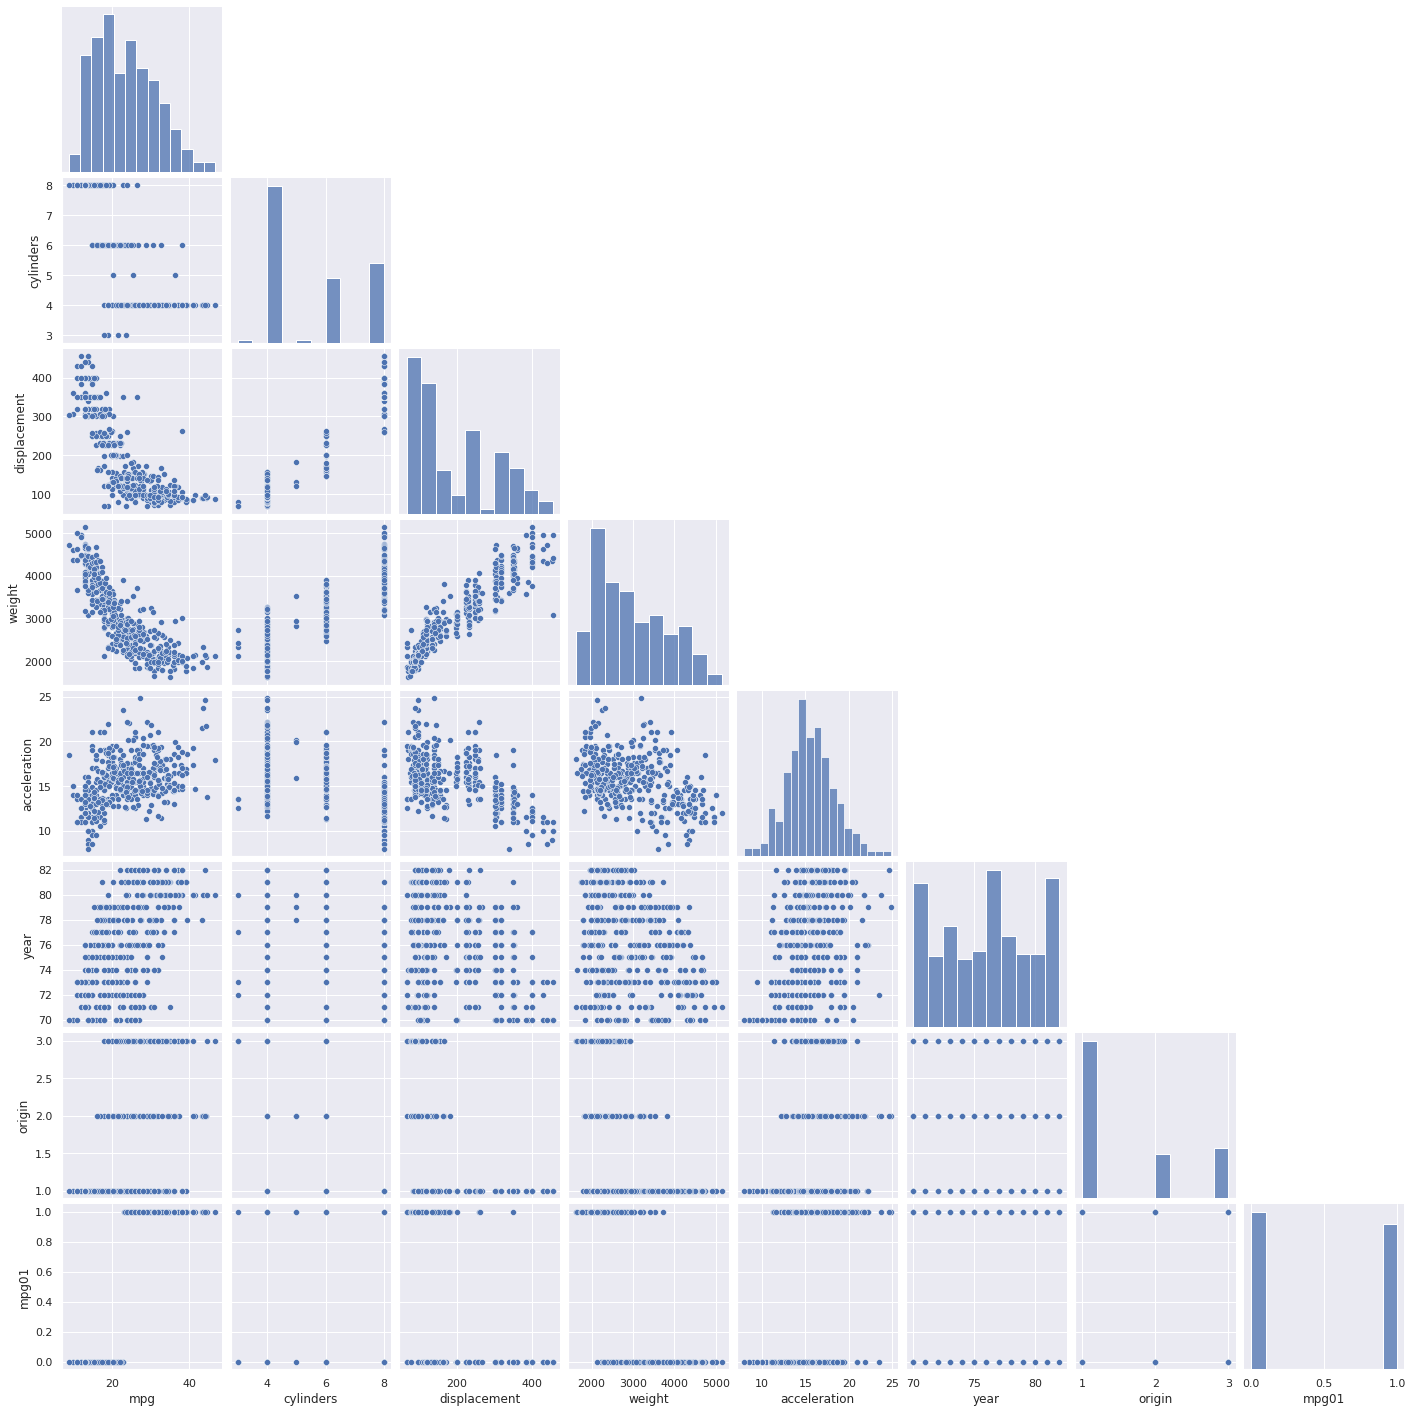

In [101]:
sns.pairplot(auto,corner=True)

In [102]:
auto.corr().round(2)

,mpg,cylinders,displacement,weight,acceleration,year,origin,mpg01
mpg,1.00,-0.78,-0.80,-0.83,0.42,0.58,0.56,0.84
cylinders,-0.78,1.00,0.95,0.90,-0.50,-0.35,-0.56,-0.74
displacement,-0.80,0.95,1.00,0.93,-0.54,-0.37,-0.61,-0.74
weight,-0.83,0.90,0.93,1.00,-0.42,-0.31,-0.58,-0.75
acceleration,0.42,-0.50,-0.54,-0.42,1.00,0.28,0.21,0.32
year,0.58,-0.35,-0.37,-0.31,0.28,1.00,0.18,0.45
origin,0.56,-0.56,-0.61,-0.58,0.21,0.18,1.00,0.51
mpg01,0.84,-0.74,-0.74,-0.75,0.32,0.45,0.51,1.00


<AxesSubplot:xlabel='mpg01', ylabel='cylinders'>

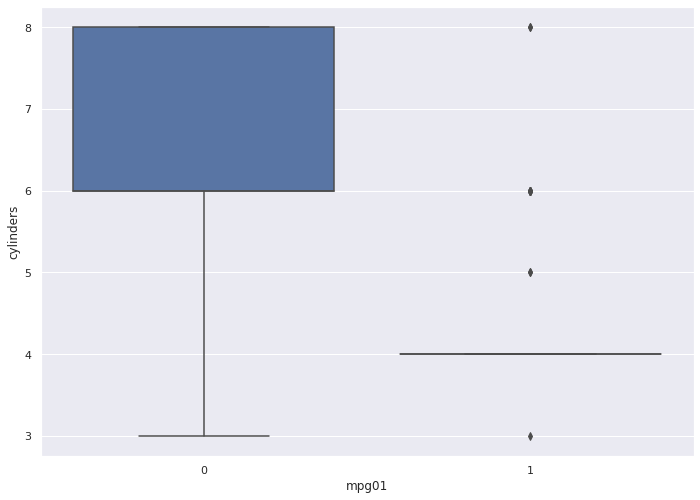

In [103]:
sns.boxplot(x=auto.mpg01, y = auto.cylinders,data=auto)

In [104]:
auto.mpg01.value_counts()

0    206
1    191
Name: mpg01, dtype: int64

<AxesSubplot:xlabel='mpg01', ylabel='displacement'>

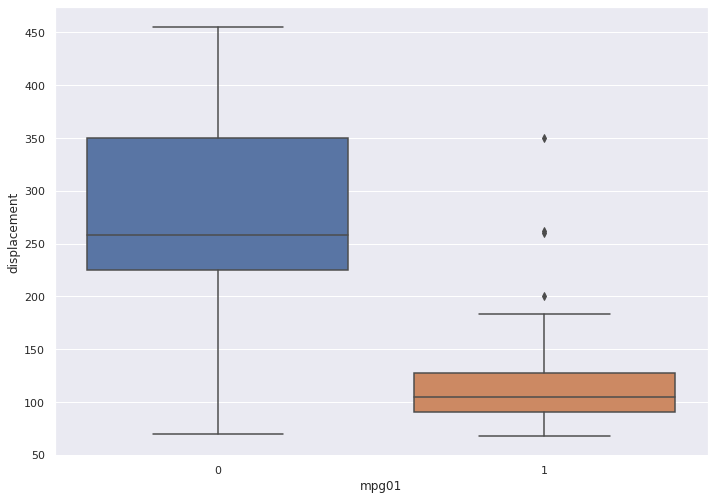

In [105]:
sns.boxplot(x=auto.mpg01, y = auto.displacement,data=auto)

<AxesSubplot:xlabel='mpg01', ylabel='weight'>

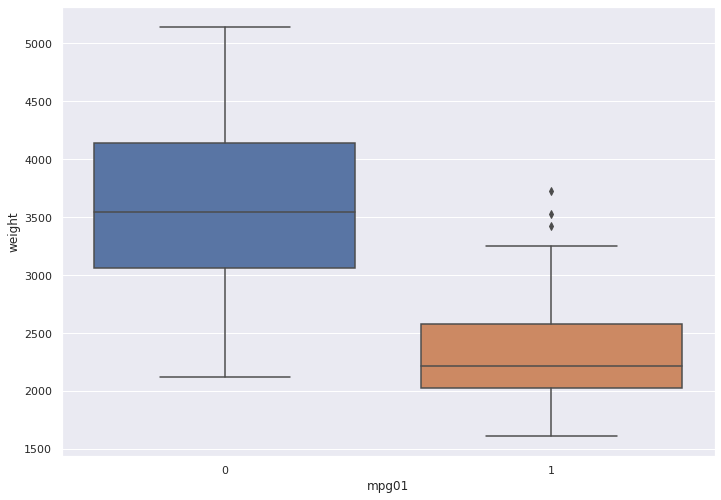

In [106]:
sns.boxplot(x=auto.mpg01, y = auto.weight,data=auto)

<AxesSubplot:xlabel='mpg01', ylabel='acceleration'>

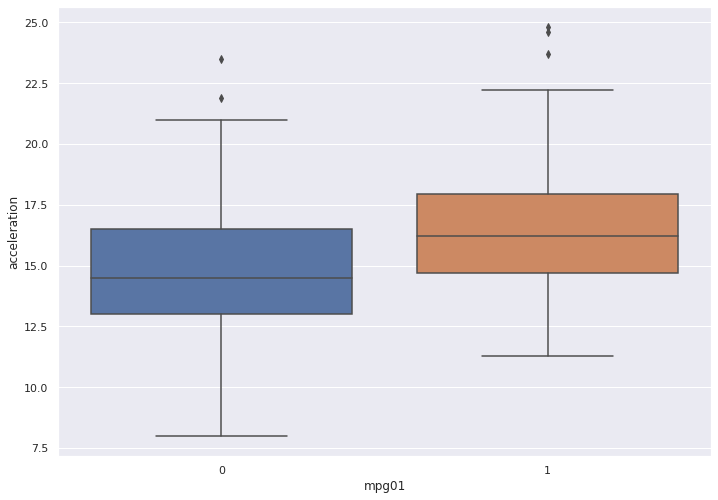

In [107]:
sns.boxplot(x=auto.mpg01, y = auto.acceleration,data=auto)

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
train, test = train_test_split(auto)

In [110]:
train.shape

(297, 11)

In [111]:
test.shape

(100, 11)

In [112]:
auto.shape

(397, 11)

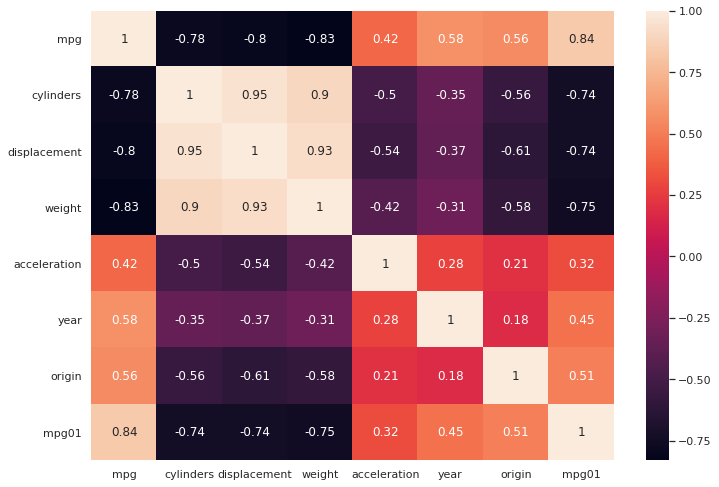

In [113]:
corr_mat = auto.corr().round(2)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(data=corr_mat, annot=True)
plt.show()

displacement, weight, originName, year, acceleration

In [114]:
#logreg 1st
model = sm.GLM.from_formula('mpg01~displacement+weight+originName+year+acceleration', family = sm.families.Binomial(), data = train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  mpg01   No. Observations:                  297
Model:                            GLM   Df Residuals:                      290
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53.610
Date:                Fri, 23 Oct 2020   Deviance:                       107.22
Time:                        17:07:14   Pearson chi2:                     130.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -31.4664      6.897     -4.563      0.000     -44.983     -17.950
originName[T.Euro]         2.0464      0.864      2.370      0.018       0.354       3.739
originName[T.Japanese]     0.6731      0.775      0.869      0.385      -0.845       2.191
displacement               0.0083      0.010      0.803      0.422      -0.012       0.029
weight                    -0.0070      0.002     -4.574      0.000      -0.010      -0.004
year                       0.6261      0.113      5.550      0.000       0.405       0.847
acceleration               0.0861      0.114      0.757      0.449      -0.137       0.309
==========================================================================================
"""

In [115]:
#logreg 1st
model = sm.GLM.from_formula('mpg01~cylinders+weight+originName+year+acceleration', family = sm.families.Binomial(), data = train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  mpg01   No. Observations:                  297
Model:                            GLM   Df Residuals:                      290
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53.921
Date:                Fri, 23 Oct 2020   Deviance:                       107.84
Time:                        17:09:57   Pearson chi2:                     134.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -30.2755      6.873     -4.405      0.000     -43.746     -16.805
originName[T.Euro]         1.6523      0.723      2.287      0.022       0.236       3.068
originName[T.Japanese]     0.4021      0.693      0.581      0.562      -0.955       1.759
cylinders                  0.0315      0.364      0.087      0.931      -0.682       0.745
weight                    -0.0062      0.001     -5.195      0.000      -0.008      -0.004
year                       0.5989      0.107      5.617      0.000       0.390       0.808
acceleration               0.0707      0.113      0.625      0.532      -0.151       0.292
==========================================================================================
"""

In [118]:
'mpg01~displacement+weight+originName+year+acceleration'
X_train = train.loc[:,['displacement','weight','origin','year','acceleration']]
Y_train = train['mpg01']

X_test = test.loc[:,['displacement','weight','origin','year','acceleration']]
Y_test = test['mpg01']

In [121]:
logreg = LogisticRegression(C=1e19)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], logreg.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], logreg.classes_])
cfmat = confusion_matrix(Y_test, Y_pred, labels=logreg.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, Y_pred))


Confusion Matrix: 


/home/jordan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Predict    
             0   1
True 0      42   8
     1       4  46

              precision    recall  f1-score   support

           0       0.91      0.84      0.87        50
           1       0.85      0.92      0.88        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100



In [122]:
Y_test.value_counts()

1    50
0    50
Name: mpg01, dtype: int64

In [123]:
#only significant IVs
X_trainSig = train.loc[:,['weight','origin','year']]
X_testSig = test.loc[:,['weight','origin','year']]

logreg = LogisticRegression(C=1e19)
logreg.fit(X_trainSig, Y_train)
Y_pred = logreg.predict(X_testSig)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], logreg.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], logreg.classes_])
cfmat = confusion_matrix(Y_test, Y_pred, labels=logreg.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, Y_pred))


Confusion Matrix: 


Predict    
             0   1
True 0      42   8
     1       3  47

              precision    recall  f1-score   support

           0       0.93      0.84      0.88        50
           1       0.85      0.94      0.90        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [124]:
#testing LDA

lda.fit(X_train, Y_train)
Y_pred = lda.predict(X_test)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], lda.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], lda.classes_])
cfmat = confusion_matrix(Y_test, Y_pred, labels=lda.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, Y_pred))


Confusion Matrix: 


Predict    
             0   1
True 0      41   9
     1       1  49

              precision    recall  f1-score   support

           0       0.98      0.82      0.89        50
           1       0.84      0.98      0.91        50

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100



In [125]:
#testing LDA on sig

lda.fit(X_trainSig, Y_train)
Y_pred = lda.predict(X_testSig)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], lda.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], lda.classes_])
cfmat = confusion_matrix(Y_test, Y_pred, labels=lda.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, Y_pred))


Confusion Matrix: 


Predict    
             0   1
True 0      41   9
     1       2  48

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        50
           1       0.84      0.96      0.90        50

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100



In [126]:
#testing QDA

qda.fit(X_train, Y_train)
Y_pred = qda.predict(X_test)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], qda.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], qda.classes_])
cfmat = confusion_matrix(Y_test, Y_pred, labels=qda.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, Y_pred))


Confusion Matrix: 


Predict    
             0   1
True 0      42   8
     1       1  49

              precision    recall  f1-score   support

           0       0.98      0.84      0.90        50
           1       0.86      0.98      0.92        50

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



In [127]:
#testing QDA, only sig vars

qda.fit(X_trainSig, Y_train)
Y_pred = qda.predict(X_testSig)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], qda.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], qda.classes_])
cfmat = confusion_matrix(Y_test, Y_pred, labels=qda.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, Y_pred))


Confusion Matrix: 


Predict    
             0   1
True 0      42   8
     1       2  48

              precision    recall  f1-score   support

           0       0.95      0.84      0.89        50
           1       0.86      0.96      0.91        50

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100



In [128]:
#KNN k=3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
knnY_pred  = knn.predict(X_test)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], knn.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], knn.classes_])
cfmat = confusion_matrix(Y_test, knnY_pred, labels=knn.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, knnY_pred))


Confusion Matrix: 


Predict    
             0   1
True 0      41   9
     1       5  45

              precision    recall  f1-score   support

           0       0.89      0.82      0.85        50
           1       0.83      0.90      0.87        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



In [129]:
#KNN k=3, sig vars
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_trainSig, Y_train)
knnY_pred  = knn.predict(X_testSig)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], knn.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], knn.classes_])
cfmat = confusion_matrix(Y_test, knnY_pred, labels=knn.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, knnY_pred))


Confusion Matrix: 


Predict    
             0   1
True 0      43   7
     1      10  40

              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



In [135]:
#KNN k=5
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, Y_train)
knnY_pred  = knn.predict(X_test)

cfmat_cnames = pd.MultiIndex.from_product([['Predict'], knn.classes_])
cfmat_index = pd.MultiIndex.from_product([['True'], knn.classes_])
cfmat = confusion_matrix(Y_test, knnY_pred, labels=knn.classes_)
print("\nConfusion Matrix: ")
display(pd.DataFrame(cfmat, columns=cfmat_cnames, index=cfmat_index))

print(classification_report(Y_test, knnY_pred))


Confusion Matrix: 


Predict    
             0   1
True 0      40  10
     1       3  47

              precision    recall  f1-score   support

           0       0.93      0.80      0.86        50
           1       0.82      0.94      0.88        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



# QDA and LDA performed very similarly